[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/regex.ipynb)

Tento soubor je součástí sestavy elektronických studijních opor [Příběhy dat: Výpočetní přístupy ke studiu kultury a společnosti](https://github.com/CCS-ZCU/pribehy-dat/tree/master). 


# Regulární výrazy

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)

## Úvod a cíle kapitoly

V této kapitole si ukážeme základy tzv. regulárních výrazů. Regulární výrazy představují velice sofistikovaný způsob jak vyhledávat v textových datech určité řetězce znaků a případně je nahrazovat jinými řetězci znaků. Na rozdíl od standardního vyhledávání však regulární výrazy umožňují vyhledávání na abstraktnější rovině, pomocí obecnějších pravidel či "regulí". K tomu se používají speciálně nadefinované pomocné znaky. Regex je technologie, která nemá co dočinění s Pythonem - lze jej používat v mnoha různých aplikacích, včetně webových (např. https://regex101.com). 

V rámci Pythonu je pro regex dostupná velice praktická knihovna `re`, na které budou některé ukázky níže postaveny. Pro systematičtější pohled však tentokrát z našeho juypter notebooku na chvíli vystoupíme a projdeme si sérii cvičení na webové stránce https://regexone.com.

Knihovna `re` v sobě má celou řadu užitečných metod. My zde budeme pracovat jen s několika z nich. Zejména
  * `re.search(pattern, string)`: nalezne uvnitř prohledávaného řetězce znaků (parametr `string`) první výskyt (tzv. `match`) hledáného řetězce znaků (`pattern`) a poskytne nám informaci o tom, kde se hledaný řetězec nachází
  * `re.findall(pattern, string)`:  nalezne uvnitř prohledávaného řetězce znaků (parametr `string`) všechny výskyty (`matches`) hledáného řetězce znaků (`pattern`) a poskytne nám informaci o tom, kde se hledané řetězce nachází
  * `re.sub(pattern, repl, string)`:  nalezne uvnitř prohledávaného řetězce znaků (parametr `string`) všechny výskyty hledáného řetězce znaků (`pattern`) a nahradí jej řetězcem `repl`.


In [1]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
!pip install lxml
from bs4 import BeautifulSoup
from getpass import getpass
import json


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


Představte si, že chcete v dokumentu vyhledat veškéré výskyty číslic. Pomocí regexu toho lze dosáhnout pomocí použití speciálního znaku "\d".

In [22]:
# náš dokument se nachází uvnitř proměnné text
text = "Tento text obsahuje kromě znaků pro písmena i některé číslice, jako je třeba 7, 13, 542, nebo letopočet 1842 apod. Kromě toho obsahuje i některá vlastní jména, jako je třeba Jan Patočka nebo Václav Havel. To nám stačí, abychom si zde vyzkoušeli několik základních principů regexu."

Použijeme tedy metodu `re.findall()` a speciální znak "\d"

In [3]:
matches = re.findall("\d", text)
matches

['7', '1', '3', '5', '4', '2', '1', '8', '4', '2']

Nyní jsme zachytili každou číslici zvlášť. Abychom zachytili i víceciferná čísla, musíme použít tzv. kvantifikátor. V našem patternu uděláme jednu drobnou úpravu, a totiž přidáme znaménko +.

In [6]:
matches = re.findall("\d+", text)
matches

['7', '13', '542', '1842']

někdy nás třeba mohou zajímat pouze čísla o určitém počtu cifer, jako jsou letopočty, které jsou již více než tisíc let čtyřciferné a ještě několik tisíc let budou. Toho lze dosáhnout kvantifikátorem využívajícím symboly`{}`, 

In [7]:
matches = re.findall("\d{4}", text)
matches

['1842']

Detekce čísel je jen jeden možný příklad. Druhý příklad, než se pustíme do reálných dat, budou vlastní jména. Vlastní jména začínají velkými písmeny. Najděme tedy všechna slova začínající velkými písmeny:

In [27]:
re.findall("[A-Z]\w*", text)

['Tento', 'Kromě', 'Jan', 'Patočka', 'Václav', 'Havel', 'To']

Ano, je zde několik problému. Zaprvé zachycujeme také všechny slova na začátku vět. Jak tomu předejít? Můžeme například definovat, které znaky před našim patternem mít nechceme, tj. interpunkční známénku vyznačující konec věty a mezeru.

In [30]:
re.findall(r"(?<![.!?])\s([A-Z]\w*)" , text)

['Jan', 'Patočka', 'Václav', 'Havel']

Jména v našem textu sestávají ze dvou částí: křesťního jména a příjmení. Co se tedy soustředit pouze na situace, kdy se jedná o dvě slova s velkými písmeny po sobě:

In [31]:
re.findall("[A-Z]\w*\\s[A-Z]\w*", text)

['Jan Patočka', 'Václav Havel']

In [32]:
# Tato buňka slouží ke kontrole průchodu tímto cvičením. 
# Pokud toto cvičení plníte v rámci svých studijních povinností na ZČU, buňku spusťte a držte se instrukcí.
exec(requests.get("https://sciencedata.dk/shared/856b0a7402aa7c7258186a8bdb329bd3?download").text)
kontrola_pruchodu(ntb="regex", arg1="check1")

## Regulérní výrazy a metadata ze Slovníku českých filozofů


Nyní si opět načteme data ze slovníku českých filozofů, která jsme vydolovali v jedné z předchozích kapitol.

In [33]:
slovnik_df = pd.read_csv("https://raw.githubusercontent.com/CCS-ZCU/pribehy-dat/master/data/slovnik_df.csv")
slovnik_df.head(5)

,url,name,birth,death
0,http://www.phil.muni.cz/fil/scf/komplet/adam.html,Daniel Adam z Veleslavína,* 31. 8. 1546 Veleslavín u Prahy,† 18. 10. 1599 Praha
1,http://www.phil.muni.cz/fil/scf/komplet/adamik...,Richard Adamík,* 4. 4. 1867 Hranice na Moravě,† 15. 8. 1952
2,http://www.phil.muni.cz/fil/scf/komplet/albert...,František Albert,* 29. 4. 1856 Žamberk,† 22. 7. 1923 Potštejn
3,http://www.phil.muni.cz/fil/scf/komplet/albik....,Albík z Uničova,* asi 1358 Uničov,† 1427 Uhry
4,http://www.phil.muni.cz/fil/scf/komplet/alexej...,Nikolaj Alexejev,* 1. 5. 1879 Moskva,† 2. 3. 1964 Ženeva


Ve sloupcích narození a smrt vidíme, že se zde datum a místo narození objevují vždy ve víceméně shodné podobě. Zajímá-li nás např. pouze rok narození či úmrtí, mohlo by nám postačit vyhledat v každém řetězci čtyřciferná čísla. Objevují se zde však i kompletní datumy a místní názvy, kde k těmto událostem došlo.

Uvědomme si, že zde pracujeme  s objektem typu dataframe knihovny pandas. Některé věci je proto potřeba dělat trochu odlišně než na příkladech výše. Naše regexy si zabalíme do vlastních definovaných funkcí, které následně budeme aplikovat na všechny hodnoty ve vybraném sloupci najednou. Funkci níže budeme postupně upravovat tak, aby zachytila více a více zajímavýcj informací. Výhoda této funkce je, že v sobě má "pojistku" ve formě výjimku (try-except) pro situace, že se hledání nepovede, například z důvodu nevalidních vstupních dat - měli bychom se tedy vyhnout mnoha zbytečným chybovým hláškám.

In [34]:
def our_regex_matcher(string, regex_pattern):
    try:
        return re.search(regex_pattern, string).group() 
    except:
        return None

V této základní podobě funkce zachytí pouze čtyřciferné číslo, což v našem případě bude typicky letopočet: Funkci můžeme otestovat na hned první hodnotě ve sloupci "birth":

In [35]:
our_string = "* 31. 8. 1546 Veleslavín u Prahy"
our_regex_matcher(our_string, "\d{4}")

'1546'

Nyní tuto funkci aplikujeme na všechny hodnoty v celém sloupci "birth" a "death" a výsledek přiřadíme dvěma novým sloupcům: "birth_year" a "death_year" 

In [36]:
slovnik_df["birth_year"] = slovnik_df['birth'].apply(our_regex_matcher, args=("\d{4}",))
slovnik_df["death_year"] = slovnik_df['death'].apply(our_regex_matcher, args=("\d{4}",))  # 
# vypíšeme si prvních 10 řádek dataframu"
slovnik_df.head(10)


,url,name,birth,death,birth_year,death_year
0,http://www.phil.muni.cz/fil/scf/komplet/adam.html,Daniel Adam z Veleslavína,* 31. 8. 1546 Veleslavín u Prahy,† 18. 10. 1599 Praha,1546,1599
1,http://www.phil.muni.cz/fil/scf/komplet/adamik...,Richard Adamík,* 4. 4. 1867 Hranice na Moravě,† 15. 8. 1952,1867,1952
2,http://www.phil.muni.cz/fil/scf/komplet/albert...,František Albert,* 29. 4. 1856 Žamberk,† 22. 7. 1923 Potštejn,1856,1923
3,http://www.phil.muni.cz/fil/scf/komplet/albik....,Albík z Uničova,* asi 1358 Uničov,† 1427 Uhry,1358,1427
4,http://www.phil.muni.cz/fil/scf/komplet/alexej...,Nikolaj Alexejev,* 1. 5. 1879 Moskva,† 2. 3. 1964 Ženeva,1879,1964
5,http://www.phil.muni.cz/fil/scf/komplet/altr.html,Michal Altrichter,* 19. 6. 1965 Kopřivnice,NaN,1965,None
6,http://www.phil.muni.cz/fil/scf/komplet/amerl....,Karel Slavomil Amerling,* 18. 9. 1807 Klatovy,† 2. 11. 1884 Praha,1807,1884
7,http://www.phil.muni.cz/fil/scf/komplet/armbrs...,Ludvík Armbruster,NaN,NaN,None,None
8,http://www.phil.muni.cz/fil/scf/komplet/arnold...,Emanuel Arnold,* 9. 11. 1800 Mnichovo Hradiště,† 4. 1. 1869 Praha,1800,1869
9,http://www.phil.muni.cz/fil/scf/komplet/ariaga...,Rodrigo de Arriaga,* 1592 Logroňo,† 1667 Praha,1592,1667


Ač to na první pohlede není zřejmé, naše sloupce s letopočty obsahují ve skutečnosti proměnné typu string. Takže si je ještě převedeme na čísla.

In [37]:
slovnik_df["birth_year"] = slovnik_df["birth_year"].apply(lambda x: int(x) if x != None else None)
slovnik_df["death_year"] = slovnik_df["death_year"].apply(lambda x: int(x) if x != None else None)

Takto naformátované letopočty již umožňují časové temporální analýzy. Například se můžeme podívat na distribuci narození od 18. století do současnosti po dekádách. 

(1801.0, 2000.0)

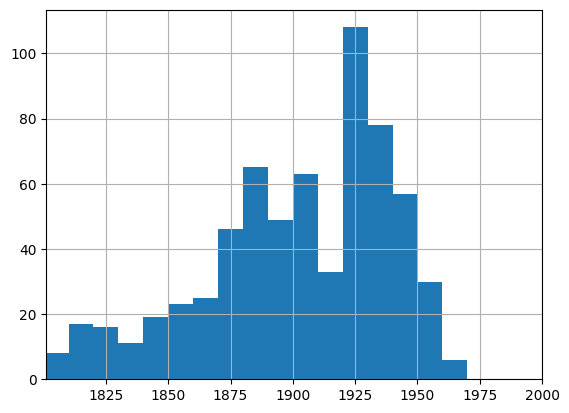

In [38]:
fig, ax = plt.subplots()
slovnik_df["birth_year"].hist(bins=range(1800, 2000, 10), ax=ax)
ax.set_xlim(1801,2000)

Vidíme zde, že nezanedbatelný počet filozofů zahrnutých ve slovníku se narodil ve 20. letech 20. století. To nemusí nutně znamenat, že by se v této dekádě rodilo více filozofických talentů, ale může to být dáno zaměřením autorů SLovníku, kteří věnovali zvláštní pozornost osobnostem své a bezprostředně předcházející generace. 

Ve sloupcích "birth" a "death" se ve většině případů nachází i informace o tom, kde k těmto událostem došlo. Tato informace se nachází bezprostředně za letopočtem a mezerou. Opět ji můžeme vyxetrahovat pomocí regexu. Vytvoříme si proto však samostatnou funkci:

In [39]:
def get_place(string, regex_pattern="(\d{4})(\s)(.+)"):
    try:
        return re.search(regex_pattern, string).groups()[2]
    except:
        return None

In [40]:
our_string = "* 31. 8. 1546 Veleslavín u Prahy"
get_place(our_string)

'Veleslavín u Prahy'

In [41]:
slovnik_df["birth_place"] = slovnik_df["birth"].apply(get_place)
slovnik_df["death_place"] = slovnik_df["death"].apply(get_place)
slovnik_df.head(5)

,url,name,birth,death,birth_year,death_year,birth_place,death_place
0,http://www.phil.muni.cz/fil/scf/komplet/adam.html,Daniel Adam z Veleslavína,* 31. 8. 1546 Veleslavín u Prahy,† 18. 10. 1599 Praha,1546.0,1599.0,Veleslavín u Prahy,Praha
1,http://www.phil.muni.cz/fil/scf/komplet/adamik...,Richard Adamík,* 4. 4. 1867 Hranice na Moravě,† 15. 8. 1952,1867.0,1952.0,Hranice na Moravě,None
2,http://www.phil.muni.cz/fil/scf/komplet/albert...,František Albert,* 29. 4. 1856 Žamberk,† 22. 7. 1923 Potštejn,1856.0,1923.0,Žamberk,Potštejn
3,http://www.phil.muni.cz/fil/scf/komplet/albik....,Albík z Uničova,* asi 1358 Uničov,† 1427 Uhry,1358.0,1427.0,Uničov,Uhry
4,http://www.phil.muni.cz/fil/scf/komplet/alexej...,Nikolaj Alexejev,* 1. 5. 1879 Moskva,† 2. 3. 1964 Ženeva,1879.0,1964.0,Moskva,Ženeva


Máme-li místa narození a úmrtí takto v samostatné podobě, můžeme se pro přehled opět podívat na jejich distribuci:

In [42]:
slovnik_df["birth_place"].value_counts()

birth_place
Praha                                   140
Brno                                     37
Plzeň                                    14
Olomouc                                  11
Bratislava                                6
                                       ... 
Žďárky u Náchoda                          1
Vratislav                                 1
Dřenice u Chrudimi                        1
Frenštát p. Radhoštěm                     1
Dolní Rozsíčka, okr. Žďár n. Sázavou      1
Name: count, Length: 440, dtype: int64

In [43]:
slovnik_df["death_place"].value_counts()

death_place
Praha                  225
Brno                    59
Bratislava              19
Olomouc                 13
Vídeň                   11
                      ... 
Metánov                  1
Uherský Brod             1
Basilej, Švýcarsko       1
Konstanz (Kostnice)      1
Netunno (Itálie)         1
Name: count, Length: 194, dtype: int64

In [ ]:
exec(requests.get("https://sciencedata.dk/shared/856b0a7402aa7c7258186a8bdb329bd3?download").text)
kontrola_pruchodu(ntb="regex", arg1="check2")

# Rozšiřující analýza 1: Automatické geokódováníí míst narození a úmrtí  

Prostorovou informaci nyní máme pouze v podobě textu. Tento formát nám však neumožňuje studovat prostorové distribuce a vztahy pomocí metod **GIS** (viz samostatná kapitola na toto téma, kde se k těmto datům možná vrátíme.

Abychom s našimi daty mohli takto pracovat, je třeba je tzv. geokódovat, tj. opatřit je koordináty zeměpisné šířky a délky. Toho lze dosáhnout buď *manuálně*, postupným procházením jednotlivých místních názvů a dohledávání jich v mapě, a nebo *automaticky*. Pro automatické vyhledávání koordinátů pro místní názvy se nabízí platforma https://www.geonames.org, která disponuje i jednoduchým **API** (viz kapitola o API).

Nejprve si vytvořme si seznam všech unikátních míst v obou sloupcích:

In [44]:
places_unique = [el for el in set(list(slovnik_df["death_place"]) + list(slovnik_df["birth_place"])) if el != None]
len(places_unique)

584

Vidíme, že máme co do činění s 584 unikátními místními názvy. Pro zkoušku si vypíšeme 10 z nich:

In [45]:
places_unique[:10]

['Kostelany u Kroměříže',
 'Vír na Moravě',
 'Broumov',
 'Vysoké nad Jizerou',
 'Dřenice u Chrudimi',
 'Málinec, okr. Lučenec',
 'Lipník nad Bečvou',
 'Chranišov',
 'Hluboká',
 'Dolná Lehota']

Nyní můžeme navštívit webovou stránku https://www.geonames.org a vytvořit si na ni účet. Účet si aktivujeme a především pro něj umožňíme používání "free webservices" (jinak nám api nebude fungovat). 

(V případě, že si např. z důvodu časové tísně nechceme účet vytvořit, následující tři buňky přeskočíme a načteme si již mnou předem získaná data.)

In [46]:
# zadáme naše uživatelské jméno
user = getpass("Enter your geonames username: ")

Níže jako hodnotu proměnné `place_string` na zkooušku zadáme název náhodně zvoleného místa. V případě, že vše funguje správně (tj. zejména že máme funkční a aktivovaný geonames účet a že jsme zvolili místní název, se kterým si platforma geonames umí poradit), buňka nám vypíše geografické koordináty:

In [49]:
place_string = "Plzeň"
resp = requests.get("http://api.geonames.org/search?q={0}&username={1}".format(place_string, user))
soup = BeautifulSoup(resp.content, "xml")
lat, lng = soup.geoname.lat.string, soup.geoname.lng.string
print(lat, lng)

49.74747 13.37759


Stejnou postup můžeme nyní aplikovat na všech 584 unikátních míst ze Slovníku. Jinými slovy, vzneseme 584 HTTP dotazů a v datech odpovědi se pokusíme identifikovat údaje o zeměpisné šířce a délce. Tato data budeme postupně přidávat do objektu `places_unique_dict` typu `dict` - klíčem bude vždy daný zeměpisný název a hodnotou příslušné koordináty.

Aplikace tohoto přístupu na celý dataset by nám však nyní zabrala příliš mboho času. V buňce níže se proto na zkoušku omezíme pouze na prvních deset položek (nejste-li omezováno časem, můžete odstranit na druhé řádce část `[:10]`).

In [50]:
places_unique_dict = {}
for place in places_unique[:10]:
    resp = requests.get("http://api.geonames.org/search?q={0}&username={1}".format(place.partition(" (")[0], user))
    try:
        soup = BeautifulSoup(resp.content, "xml")
        lat, lng = soup.geoname.lat.string, soup.geoname.lng.string
        places_unique_dict[place] = (lat, lng)
    except:
        pass

Pro kolik míst jsme úspěšně získali nějaké koordináty?

In [51]:
len(places_unique_dict)

6

In [52]:
places_unique_dict

{'Broumov': ('50.58566', '16.33181'),
 'Vysoké nad Jizerou': ('50.68559', '15.40152'),
 'Lipník nad Bečvou': ('49.52721', '17.58594'),
 'Chranišov': ('50.22101', '12.74233'),
 'Hluboká': ('49.84558', '16.07154'),
 'Dolná Lehota': ('48.83355', '19.50518')}

In [ ]:
# v případě, že pracujeme lokálně s repozitoří jako celkem, tak si data můžeme uložit pro další použití
#with open("../data/jsonplaces_unique_dict.json", 'w') as json_file:
#    json.dump(places_unique_dict, json_file)

Pokud jsme buňkami výše z neprošli (např. protože se nám nepodařilo aktivivovat účet, načteme si data v následující buňce tak, že odstraníme hashtag na začátku řádky a buňku spustíme.

In [53]:
places_unique_dict = requests.get("https://raw.githubusercontent.com/CCS-ZCU/pribehy-dat/master/data/jsonplaces_unique_dict.json").json()

Tato data nyní takříkajíc namapujeme na naše tabulková data k jednotlivým filozofům. Vytvoříme dva nové atributy: "birth_latlong" a "death_latlong".  

In [54]:
slovnik_df["birth_latlong"] = slovnik_df["birth_place"].apply(lambda x: places_unique_dict[x] if x in places_unique_dict.keys() else None)
slovnik_df["death_latlong"] = slovnik_df["death_place"].apply(lambda x: places_unique_dict[x] if x in places_unique_dict.keys() else None)

In [56]:
slovnik_df.head(5)

,url,name,birth,death,birth_year,death_year,birth_place,death_place,birth_latlong,death_latlong
0,http://www.phil.muni.cz/fil/scf/komplet/adam.html,Daniel Adam z Veleslavína,* 31. 8. 1546 Veleslavín u Prahy,† 18. 10. 1599 Praha,1546.0,1599.0,Veleslavín u Prahy,Praha,None,"[50.08804, 14.42076]"
1,http://www.phil.muni.cz/fil/scf/komplet/adamik...,Richard Adamík,* 4. 4. 1867 Hranice na Moravě,† 15. 8. 1952,1867.0,1952.0,Hranice na Moravě,None,"[49.54796, 17.73469]",None
2,http://www.phil.muni.cz/fil/scf/komplet/albert...,František Albert,* 29. 4. 1856 Žamberk,† 22. 7. 1923 Potštejn,1856.0,1923.0,Žamberk,Potštejn,"[50.08601, 16.46738]","[50.08209, 16.30892]"
3,http://www.phil.muni.cz/fil/scf/komplet/albik....,Albík z Uničova,* asi 1358 Uničov,† 1427 Uhry,1358.0,1427.0,Uničov,Uhry,"[49.77092, 17.12144]","[49.72982, 23.61574]"
4,http://www.phil.muni.cz/fil/scf/komplet/alexej...,Nikolaj Alexejev,* 1. 5. 1879 Moskva,† 2. 3. 1964 Ženeva,1879.0,1964.0,Moskva,Ženeva,"[55.75222, 37.61556]","[46.20222, 6.14569]"


In [57]:
# pokud pracujeme lokálně s repozitoří jako celkem, tato data si uložíme pro budoucí použití.
slovnik_df.to_json("slovnik_geotemporal_df.json")

# Rozšiřující analýza 2: Prostorové vizualizace


In [69]:
from shapely.geometry import Point
import geopandas as gpd
!pip install folium
import folium

In [81]:
death_geometry = []
for yx in slovnik_df['death_latlong']:
    if yx != None:
        lat, lon = yx  # Correctly assign longitude and latitude
        death_geometry.append(Point(lon, lat))  # Create Point with correct coordinates
birth_geometry = []
for yx in slovnik_df['birth_latlong']:
    if yx != None:
        lat, lon = yx  # Correctly assign longitude and latitude
        birth_geometry.append(Point(lon, lat))

In [82]:
prague_coords = (50.0755, 14.4378)
m = folium.Map(location=prague_coords, zoom_start=10, control_scale=True)

for point in birth_geometry:
    if point is not None:
        folium.Marker([point.y, point.x],  icon=folium.Icon(color='green')).add_to(m)
for point in death_geometry:
    if point is not None:
        folium.Marker([point.y, point.x],  icon=folium.Icon(color='red')).add_to(m)
m